<a href="https://colab.research.google.com/github/alura-es-cursos/Inmersion-en-Datos-con-Python/blob/aula02/credito_banco_aleman_inmersion_Dia2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



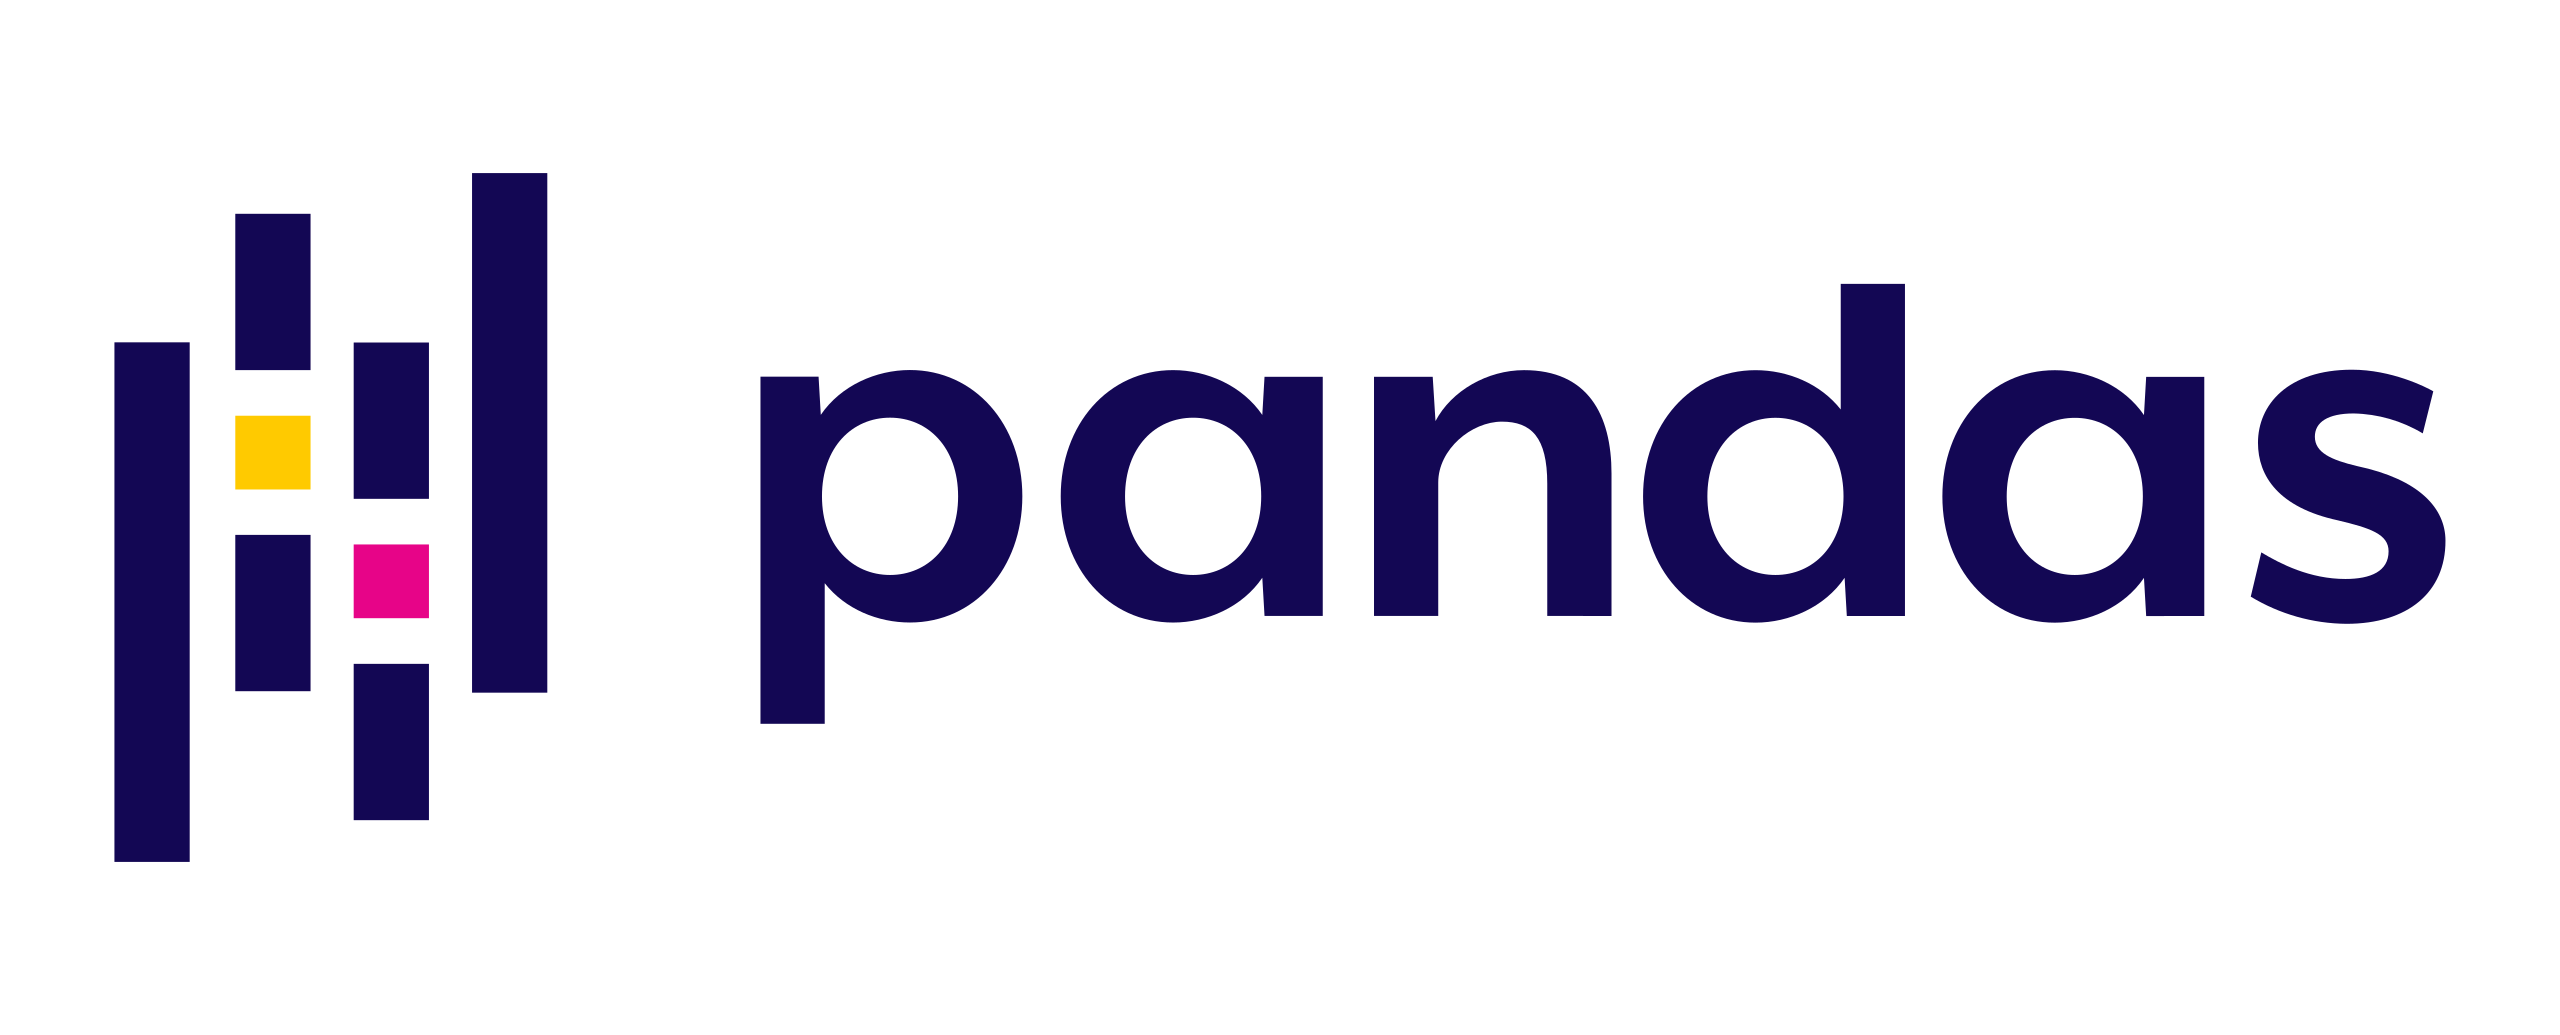

# **Sobre el desafio**

Vamos a contruir un Robot Trading en Python capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real. Basandonos en la media de el valor de cirre en un hiscorico de 7 dias en intervalos de 5 minutos.

# 1. **Configuración del ambiente**

In [50]:
from IPython.display import clear_output
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import time

# variables globales que seutilizaran en el proyecto
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

In [51]:
# comprobar las verciones de las librerias

!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'


Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.25.2
------
Name: matplotlib
Version: 3.7.1


# 2. **Obtención de datos**

In [52]:
def importar_base_bitcoin():
    """
    Importa datos históricos de precios de Bitcoin y crea un DataFrame con ellos.

    Esta función utiliza la biblioteca yfinance para obtener datos históricos de precios de Bitcoin
    para los últimos 7 días con un intervalo de 5 minutos y los almacena en un DataFrame.

    Args:
        No recibe argumentos.

    Returns:
        None

    Global Variables:
        df_bitcoin (pandas.DataFrame): Almacena el DataFrame con los datos históricos de precios de Bitcoin.
        precio_actual (float): Almacena el precio actual de Bitcoin.
        tendencia (str): Almacena la tendencia de los precios de Bitcoin.
        media_bitcoin (float): Almacena la media de los precios de Bitcoin.
        algoritmo_decision (str): Almacena el algoritmo de decisión utilizado para analizar los datos.

    Raises:
        yfinance.YFinanceError: Si hay un error al obtener los datos históricos de precios de Bitcoin.
        Exception: Si ocurre un error inesperado durante la ejecución de la función.

    Example:
        >>> importar_base_bitcoin()
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

    try:
        # Crear un objeto Ticker para Bitcoin
        ticker = yf.Ticker("BTC-USD")
        # Obtener datos históricos de precios para 7 días
        historico_btc = ticker.history(period="7d", interval='5m')
    except yf.YFinanceError as e:
        print("Error al obtener datos históricos:", e)
    except Exception as e:
        print(type(e), f'No es posible completar la operacion -> Erro: {e}')
    else:
        # crear df del historioco del btc para 7 dias en intervalo de 5 minutos
        df_bitcoin = pd.DataFrame(historico_btc)

In [53]:
def extraer_tendencias():
    """
    Esta función extrae las tendencias actuales del mercado de Bitcoin desde el sitio web CoinMarketCap.
    Actualiza las variables globales df_bitcoin, precio_actual, tendencia, media_bitcoin y algoritmo_decision.

    Raises:
    - requests.exceptions.RequestException: Si ocurre un error al realizar la solicitud a la URL.
    - AttributeError: Si hay un error al analizar el HTML de la página debido a un atributo no encontrado.
    - TypeError: Si hay un error al analizar el HTML de la página debido a un tipo de dato incorrecto.
    - Exception: Si ocurre algún otro error no previsto.

    La función actualiza las variables globales:
    - precio_actual: El precio actual de Bitcoin.
    - tendencia: La tendencia actual del precio de Bitcoin ('alta' si hay un aumento, 'baja' si hay una disminución).
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
    url = 'https://coinmarketcap.com/'

    try:
        # peticiones a la url
        respuesta = requests.get(url)
        # Levantar una excepción si la solicitud no es exitosa
        respuesta.raise_for_status()

        # contenido de la url
        soup = BeautifulSoup(respuesta.content, 'lxml')

        # extraer precio actual de la pagina
        precio_extraido = soup.find('div', class_= ["sc-500f568e-0 ejtlWy", "sc-500f568e-0 ejtlWy rise", "sc-500f568e-0 ejtlWy fall"])
        precio_actual = float(precio_extraido.text.replace('$', '').replace(',', ''))
        # variación de precio en la última hora
        variacion_precio = soup.find('span', class_='sc-6a54057-0 YXxPZ')
        # extaer valor de la tendencia
        valor_tendencia = variacion_precio.text.strip()
    except requests.exceptions.RequestException as e:
        print("Error al realizar la solicitud a la URL:", e)
    except (AttributeError, TypeError) as e:
        print("Error al analizar el HTML de la página:", e)
    except Exception as e:
        print(type(e), f'No es posible completar la operacion -> Erro: {e}')
    else:
        tendencia = 'alta' if '+' in valor_tendencia else 'baja'

# 3. **Limpieza de datos**

In [54]:
def limpieza_datos():
    """
    Realiza limpieza de datos en el DataFrame df_bitcoin.

    Esta función realiza una serie de pasos para limpiar el DataFrame df_bitcoin, incluyendo la eliminación de duplicados,
    valores nulos, valores atípicos (outliers) y la selección de registros dentro del rango intercuartílico.

    No tiene parámetros de entrada, pero depende de las variables globales df_bitcoin, precio_actual, tendencia,
    media_bitcoin y algoritmo_decision.

    La función realiza los siguientes pasos:
    1. Copia el DataFrame df_bitcoin y selecciona solo las columnas 'Close' y 'Volume'.
    2. Elimina duplicados en el índice Datetime.
    3. Elimina filas con valores nulos en la columna 'Close'.
    4. Filtra valores de 'Volume' mayores a 0 y elimina las filas correspondientes.
    5. Grafica un boxplot del precio de cierre del Bitcoin.
    6. Identifica outliers basados en el rango intercuartílico y los elimina.
    7. Filtra los registros entre el 1er cuartil y el 3er cuartil del precio de cierre.
    8. Calcula el precio promedio de la selección y lo guarda en la variable global media_bitcoin.

    Ejemplo de uso:
    limpieza_datos()
    print(media_bitcoin)  # Imprime el precio promedio de Bitcoin después de la limpieza de datos.
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

    df_bitcoin_copy = df_bitcoin.copy()
    df_bitcoin_copy = df_bitcoin_copy[['Close', 'Volume']]
    # eliminar duplicados en el index Datetime
    df_bitcoin_copy.index = df_bitcoin_copy.index.drop_duplicates()
    # eliminar nulos en columna Close
    df_bitcoin_copy = df_bitcoin_copy.dropna(subset=['Close'])
    # filtrar por valores mayores a 0 y eliminarlos
    filtro = df_bitcoin_copy['Volume'] > 0
    df_bitcoin_copy = df_bitcoin_copy[filtro]

    # identificar y eliminar outliers
    # graficar boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_bitcoin_copy['Close'])
    plt.title('Boxplot del Precio de Cierre del Bitcoin')
    plt.ylabel('Precio de Cierre')
    plt.show()
    print('\n')
    # Identificar outliers basados en el criterio del rango intercuartílico
    Q1 = df_bitcoin_copy['Close'].quantile(0.25)
    Q3 = df_bitcoin_copy['Close'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_bitcoin_copy['Close'] < (Q1 - 1.5 * IQR)) | (df_bitcoin_copy['Close'] > (Q3 + 1.5 * IQR))
    # Eliminar outliers
    df_bitcoin_copy = df_bitcoin_copy[~outliers]

    # Filtrar los registros entre el 1er cuartil y el 3er cuartil
    Q1 = df_bitcoin_copy['Close'].quantile(0.25)
    Q3 = df_bitcoin_copy['Close'].quantile(0.75)
    df_bitcoin_limpio = df_bitcoin_copy[(df_bitcoin_copy['Close'] >= Q1) & (df_bitcoin_copy['Close'] <= Q3)]

    # Calcular el precio promedio de la selección
    media_bitcoin = df_bitcoin_limpio['Close'].mean()


# 4. **Tomar decisiones**

In [55]:
def tomar_decisiones():
    """
    Toma decisiones basadas en el precio actual de Bitcoin, la tendencia y la media del precio histórico.

    Esta función toma decisiones de compra, venta o espera dependiendo de la relación entre el precio actual de Bitcoin,
    la tendencia actual y la media histórica del precio.

    Dependencias:
    - df_bitcoin: DataFrame que contiene los datos históricos de Bitcoin.
    - precio_actual: Precio actual de Bitcoin.
    - tendencia: Tendencia actual del mercado ('alta' o 'baja').
    - media_bitcoin: Media histórica del precio de Bitcoin.
    - algoritmo_decision: Variable global que almacena la decisión tomada ('Vender', 'Comprar' o 'Esperar').

    La función realiza las siguientes comparaciones:
    - Si el precio actual es mayor o igual que la media histórica y la tendencia es 'baja', la decisión es 'Vender'.
    - Si el precio actual es menor que la media histórica y la tendencia es 'alta', la decisión es 'Comprar'.
    - En cualquier otro caso, la decisión es 'Esperar'.
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

# 5. **Visualización**

In [56]:
def visualizacion():
    """
    Función para visualizar gráficamente los datos del precio actual de Bitcoin y su promedio.

    Esta función utiliza los datos globales df_bitcoin, precio_actual, tendencia, media_bitcoin y algoritmo_decision
    para generar una gráfica que muestra el precio actual de Bitcoin y su promedio histórico.

    La gráfica también incluye una anotación que muestra la decisión calculada por el algoritmo.

    Dependencias:
    - df_bitcoin: DataFrame que contiene los datos históricos de Bitcoin.
    - precio_actual: Precio actual de Bitcoin.
    - tendencia: Tendencia actual del mercado ('alta' o 'baja').
    - media_bitcoin: Media histórica del precio de Bitcoin.
    - algoritmo_decision: Variable global que almacena la decisión tomada ('Vender', 'Comprar' o 'Esperar').

    Ejemplo de uso:
    visualizacion()
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
    # Adicion columna (Promedio) al dataframe original df_bitcoin y almacena media_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin

    # grafico
    plt.figure(figsize=(16,5))
    plt.title('Grafica Valor Bitcoin')
    df_bitcoin['Close'].plot(label='Precio Bitcoin')
    df_bitcoin['Promedio'].plot(label='Promedio')

    plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
             xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] + 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')

    plt.legend()
    plt.show()


# 6. **Automatización**

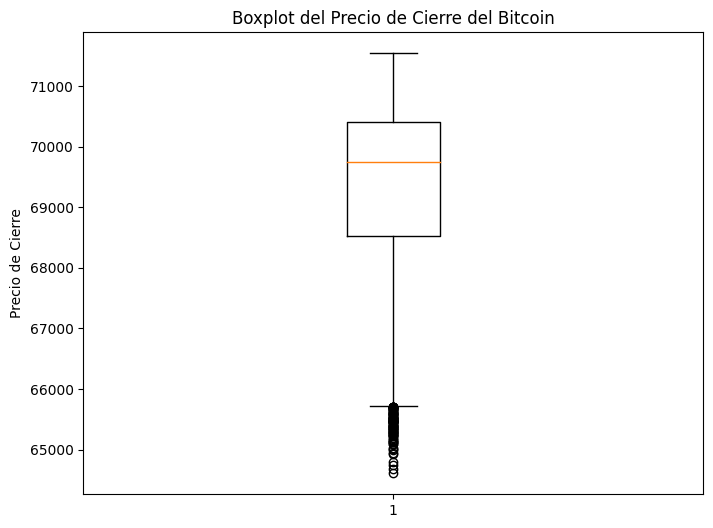

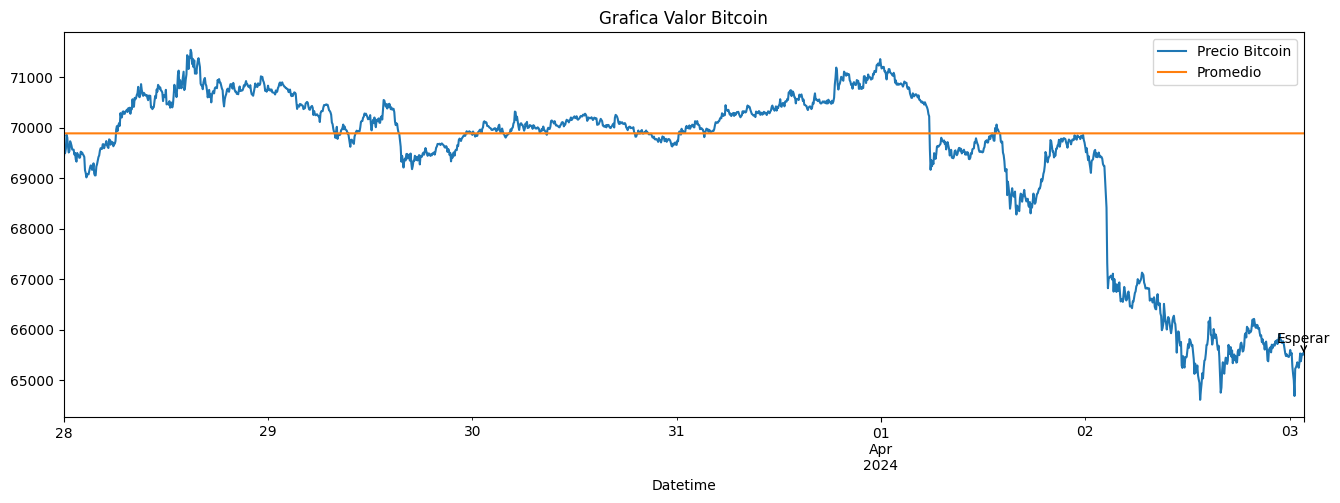

In [ ]:
while(True):
    """
    Ejecuta un ciclo infinito que realiza varias tareas relacionadas con el análisis y visualización de datos de Bitcoin.

    Este bucle ejecuta continuamente una serie de pasos para analizar y visualizar datos de Bitcoin, incluyendo la importación
    de datos, extracción de tendencias, limpieza de datos, toma de decisiones y visualización de resultados. Después de cada
    iteración, espera 300 segundos (5 minutos) antes de comenzar la siguiente iteración.

    Funciones llamadas:
    - importar_base_bitcoin(): Importa datos actualizados de Bitcoin.
    - extraer_tendencias(): Extrae las tendencias actuales del mercado.
    - limpieza_datos(): Realiza la limpieza de los datos de Bitcoin.
    - tomar_decisiones(): Toma decisiones basadas en los datos analizados.
    - visualizacion(): Genera y muestra visualizaciones de los datos y decisiones tomadas.
    - time.sleep(300): Espera 300 segundos (5 minutos) antes de la siguiente iteración.

    Nota: Este bucle se ejecuta indefinidamente hasta que se detenga manualmente.
    """
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)